<a href="https://colab.research.google.com/github/summerolmstead/Apple-Stock-Visualization/blob/main/Apple_Stock_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summer Olmstead

Data Visualization | Assignment 1 Part 3

Apple Stock 2015-2020 Visualizations

https://www.kaggle.com/datasets/suyashlakhani/apple-stock-prices-20152020

In [ ]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("suyashlakhani/apple-stock-prices-20152020")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/suyashlakhani/apple-stock-prices-20152020/versions/1


In [ ]:
dataset_files = os.listdir(path)
print("Dataset files:", dataset_files)

Dataset files: ['AAPL.csv']


In [ ]:
csv_file_path = os.path.join(path, 'AAPL.csv')
df = pd.read_csv(csv_file_path)

print(df.head()) # seeing structure of data set and columns etc

   Unnamed: 0 symbol                       date    close     high     low  \
0           0   AAPL  2015-05-27 00:00:00+00:00  132.045  132.260  130.05   
1           1   AAPL  2015-05-28 00:00:00+00:00  131.780  131.950  131.10   
2           2   AAPL  2015-05-29 00:00:00+00:00  130.280  131.450  129.90   
3           3   AAPL  2015-06-01 00:00:00+00:00  130.535  131.390  130.05   
4           4   AAPL  2015-06-02 00:00:00+00:00  129.960  130.655  129.32   

     open    volume    adjClose     adjHigh      adjLow     adjOpen  \
0  130.34  45833246  121.682558  121.880685  119.844118  120.111360   
1  131.86  30733309  121.438354  121.595013  120.811718  121.512076   
2  131.23  50884452  120.056069  121.134251  119.705890  120.931516   
3  131.20  32112797  120.291057  121.078960  119.844118  120.903870   
4  129.86  33667627  119.761181  120.401640  119.171406  119.669029   

   adjVolume  divCash  splitFactor  
0   45833246      0.0          1.0  
1   30733309      0.0          1.0  

Preprocessing

In [ ]:
#check for missing values
df.isnull().sum()

,0
Unnamed: 0,0
symbol,0
date,0
close,0
high,0
low,0
open,0
volume,0
adjClose,0
adjHigh,0


In [ ]:
#clean data formatting
#'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

#'date' column as the index
df.set_index('date', inplace=True)

#extract useful components like year, month, and day
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [ ]:
#Min-Max scaling if needed (ex: for price vs. volume) -> to normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['open', 'close', 'high', 'low', 'volume']] = scaler.fit_transform(df[['open', 'close', 'high', 'low', 'volume']])


In [ ]:
# for stocks, the more math the better to capture the relationships between each day so we will add some math to capture this window/pattern
#30-day moving average for 'close' price
df['30_day_MA'] = df['close'].rolling(window=30).mean()

#90-day moving average for 'close' price
df['90_day_MA'] = df['close'].rolling(window=90).mean()

In [ ]:
# to get a bigger understanding on stock returns, we will calculate the daily returns
df['daily_return'] = df['close'].pct_change() * 100  #percentage change of close

In [ ]:
# identify outliers using IQR for volume and close
Q1 = df['volume'].quantile(0.25)
Q3 = df['volume'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['volume'] < (Q1 - 1.5 * IQR)) | (df['volume'] > (Q3 + 1.5 * IQR))]

#alternatively, use Z-scores for outlier detection
from scipy.stats import zscore
df['zscore'] = zscore(df['volume'])
outliers = df[df['zscore'].abs() > 3]  # Z-score threshold of 3 indicates an outlier

Visualizations

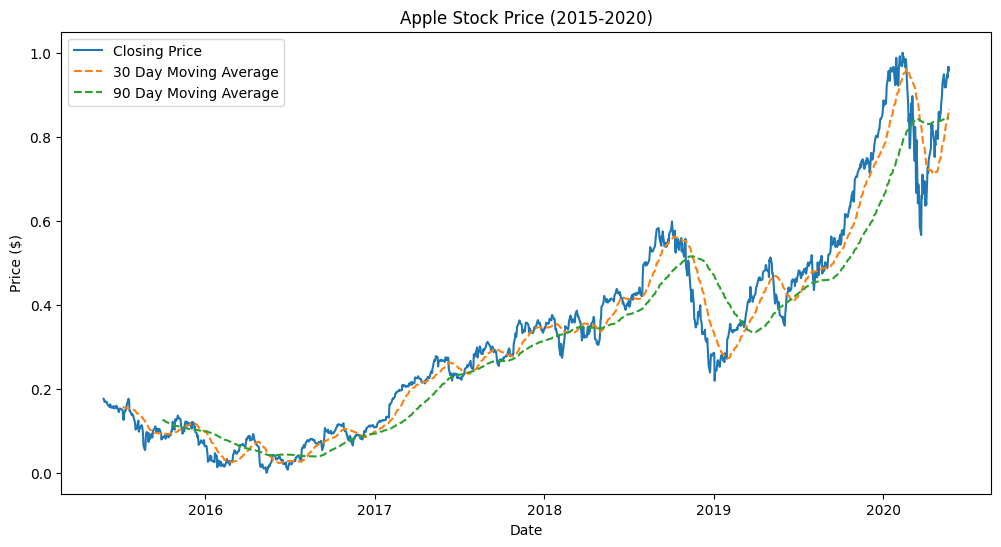

In [ ]:
import matplotlib.pyplot as plt

#visualizing closing price over time
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Closing Price')
plt.plot(df['30_day_MA'], label='30 Day Moving Average', linestyle='--')
plt.plot(df['90_day_MA'], label='90 Day Moving Average', linestyle='--')
plt.title("Apple Stock Price (2015-2020)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

#this is to show if the closing is higher or lower than the openning and visually shows it in red or green for that day
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'],
                                     name="Apple Stock Price")])

fig.update_layout(title='Apple Stock Candlestick Chart (2015-2020)',
                  xaxis_title='Date',
                  yaxis_title='Price ($)',
                  xaxis_rangeslider_visible=False)
fig.show()

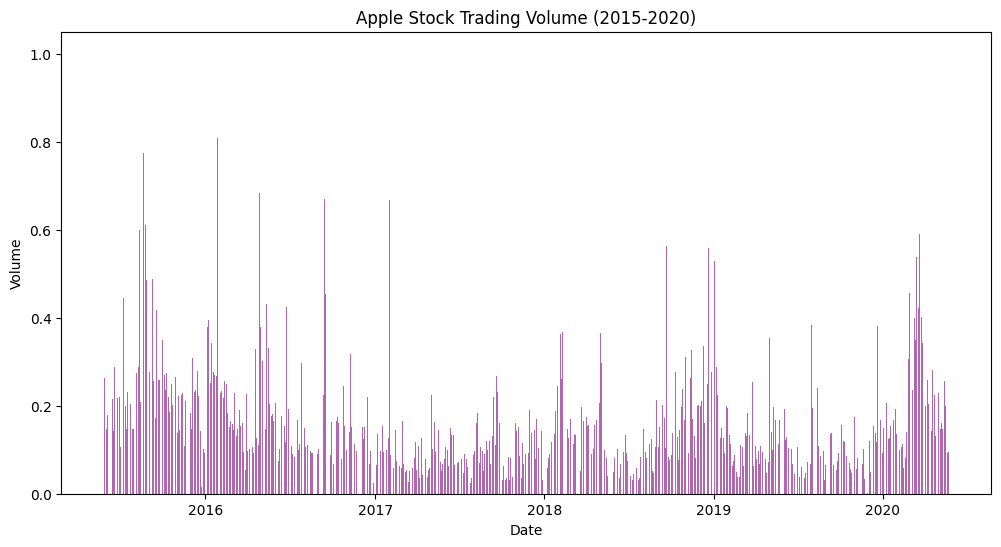

In [ ]:
#volume traded over time
plt.figure(figsize=(12,6))
plt.bar(df.index, df['volume'], color='purple', alpha=0.6)
plt.title("Apple Stock Trading Volume (2015-2020)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

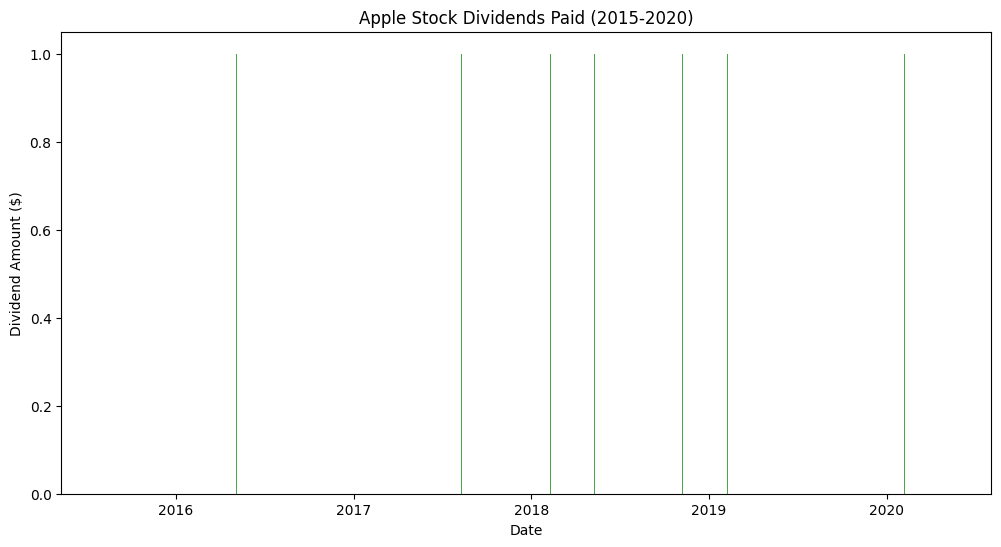

In [ ]:
#dividends paid by apple over time
dividend_days = df[df['divCash'] > 0]

plt.figure(figsize=(12,6))
plt.bar(dividend_days.index, dividend_days['divCash'], color='green', alpha=0.7)
plt.title("Apple Stock Dividends Paid (2015-2020)")
plt.xlabel("Date")
plt.ylabel("Dividend Amount ($)")
plt.show()

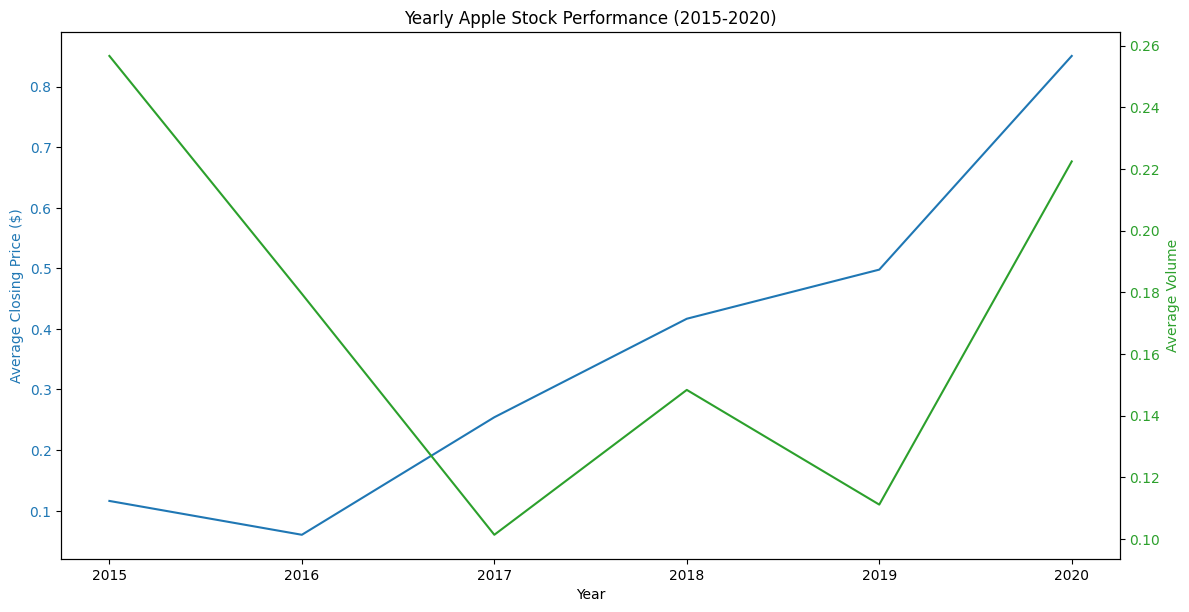

In [ ]:
#yearly performance
df['year'] = df.index.year

#group by year and calculate the mean of each column
yearly_performance = df.groupby('year').agg({'close': 'mean', 'volume': 'mean'})

#plot yearly closing price and volume
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Average Closing Price ($)', color='tab:blue')
ax1.plot(yearly_performance.index, yearly_performance['close'], color='tab:blue', label='Avg Closing Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Volume', color='tab:green')
ax2.plot(yearly_performance.index, yearly_performance['volume'], color='tab:green', label='Avg Volume')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
plt.title("Yearly Apple Stock Performance (2015-2020)")
plt.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd

#lets make an interactive plot!

df = df.reset_index()  #reset index so that 'date' becomes a column again

#configuring the 3 axises
fig = go.Figure(data=[go.Scatter3d(
    x=df['date'],
    y=df['close'],
    z=df['volume'],
    mode='markers',
    marker=dict(size=5, color=df['close'], colorscale='Viridis')
)])

#this is the axises
fig.update_layout(
    scene=dict(
        xaxis_title='Date',
        yaxis_title='Price',
        zaxis_title='Volume'
    ),
    title='3D Stock Prices with Volume'
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd

#update interactive plot to become with dark background and have color based on if the closing price is higher or lower than the opening price
df = df.reset_index()

#new column 'color' based on the comparison of 'close' and 'open'
df['color'] = df['close'] > df['open']
df['color'] = df['color'].map({True: 'green', False: 'red'})

#create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df['date'],
    y=df['close'],
    z=df['volume'],
    mode='markers',
    marker=dict(
        size=5,
        color=df['color'].map({'green': 'green', 'red': 'red'}),  #use green or red based on 'color' column
        colorscale='Viridis'
    )
)])

#update layout with dark background
fig.update_layout(
    scene=dict(
        xaxis_title='Date',
        yaxis_title='Price',
        zaxis_title='Volume'
    ),
    title='3D Apple Stock Prices with Volume (Green/Red Based on Close Price +|- Open Price)',
    plot_bgcolor='black',  #set background to black to give it that stock vibe
    paper_bgcolor='black',  #set outer paper background to black
    font=dict(color='white'),  #set text color to white
    title_font=dict(size=20, color='white'),
    margin=dict(l=0, r=0, b=0, t=40),  #adjust margins for better fit
)

fig.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/DataVisualization/3d_stock_plot2.html'
fig.write_html(file_path) #writing this to save this interactive stock plot to my drive lol